# Part 1: Prediction quality vs feature selection

### 1. repeatedly simulate new datasets,
### 2. determine λmin and λ1se using cross-validation on the training data,
### 3. compare the two resulting Lasso models with respect to:
####    * Mean squared error on the training as well as test data
####   * Feature selection quality in comparison to the original simulated regression coefficients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

In [2]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

In [3]:
from itertools import product

repetitions = 5

# Set of sample sizes and levels of sparsity to simulate data from
sample_sizes = [200, 500, 750]
sparsity = [0.75, 0.90, 0.95, 0.99]

datasets = []

# Simluate data (X, y, beta) 5 times for each combination 
for n, s in product(sample_sizes, sparsity):
    temp = []
    for i in range(repetitions):
        sample = simulate_data(n=n, p=1000, rng=np.random.default_rng(), sparsity=s, SNR=2.0, beta_scale=5.0) 
        temp.append(sample)
    datasets.append(temp)

In [4]:
# Split each dataset into train and test sets
test_size = 0.25

train_datasets = []
test_datasets = []

# For each data simluation setting...
for dataset in datasets:
    # Temporary storage for train and test splits from identical distribution
    temp1 = []
    temp2 = []

    # Train/test-split for particular sample size 
    split = int(np.floor(test_size * dataset[0][0].shape[0]))

    # For each sample from current distribution...
    for sample in dataset:
        X, y = sample[0], sample[1]
        
        X_train, y_train = X[split:], y[split:]
        X_test, y_test = X[:split], y[:split]

        temp1.append((X_train, y_train))
        temp2.append((X_test, y_test))
    
    train_datasets.append(temp1)
    test_datasets.append(temp2)

In [5]:
from sklearn.linear_model import LassoCV

alpha_min = []
alpha_1se = [] 

for dataset in train_datasets:
    # Temporary storage for alpha_min & alpha_1se
    temp1 = []
    temp2 = []

    for sample in dataset:

        X_train, y_train = sample[0], sample[1]
    
        # Fit Lasso regressor to training data 
        lasso = LassoCV(cv=5, n_alphas=100).fit(X_train, y_train)

        # Get alternative to optimal alpha
        cv_mean = np.mean(lasso.mse_path_, axis=1)
        cv_std = np.std(lasso.mse_path_, axis=1)
        idx_min_mean = np.argmin(cv_mean)
        idx_alpha = np.where(
            (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
            (cv_mean >= cv_mean[idx_min_mean]))[0][0]

        # Store min and 1se alphas
        temp1.append(lasso.alpha_)
        temp2.append(lasso.alphas_[idx_alpha])

    alpha_min.append(temp1)
    alpha_1se.append(temp2)

In [6]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Number of different distribution settings for data simulation
n_distributions = len(datasets)

train_scores_alpha_min = []
test_scores_alpha_min = []

train_scores_alpha_1se = []
test_scores_alpha_1se = []

coefs_alpha_min = []
coefs_alpha_1se = []


for i in range(n_distributions):
    # Temporary storage of beta vectors for alpha_min & alpha_1se
    temp1 = []
    temp2 = []
    # Temporary storage of train & test MSE from alpha_min
    temp3 = []
    temp4 = []
    # Temporary storage of train & test MSE from alpha_1se
    temp5 = []
    temp6 = []

    for j in range(repetitions):

        X_train, y_train = train_datasets[i][j][0], train_datasets[i][j][1]
        X_test, y_test = test_datasets[i][j][0], test_datasets[i][j][1]

        # Fit two Lasso regressors using alpha_min, alpha_1se (from same dataset) respectively
        lasso_min = Lasso(alpha=alpha_min[i][j]).fit(X_train, y_train)
        lasso_1se = Lasso(alpha=alpha_1se[i][j]).fit(X_train, y_train)

        # Get and store coefficients of each lasso regressor
        temp1.append(lasso_min.coef_)
        temp2.append(lasso_1se.coef_)

        # Get train and test predictions each lasso regressor
        train_mse_alpha_min = mean_squared_error(y_train, lasso_min.predict(X_train))
        test_mse_alpha_min = mean_squared_error(y_test, lasso_min.predict(X_test))

        train_mse_alpha_1se = mean_squared_error(y_train, lasso_1se.predict(X_train))
        test_mse_alpha_1se = mean_squared_error(y_test, lasso_1se.predict(X_test))
        
        # Store prediction results 
        temp3.append(train_mse_alpha_min)
        temp4.append(test_mse_alpha_min)

        temp5.append(train_mse_alpha_1se)
        temp6.append(test_mse_alpha_1se)


    coefs_alpha_min.append(temp1)
    coefs_alpha_1se.append(temp2)

    # Store mean of MSE from 'same' distribution
    train_scores_alpha_min.append(np.mean(temp3))
    test_scores_alpha_min.append(np.mean(temp4))
    train_scores_alpha_1se.append(np.mean(temp5))
    test_scores_alpha_1se.append(np.mean(temp6))


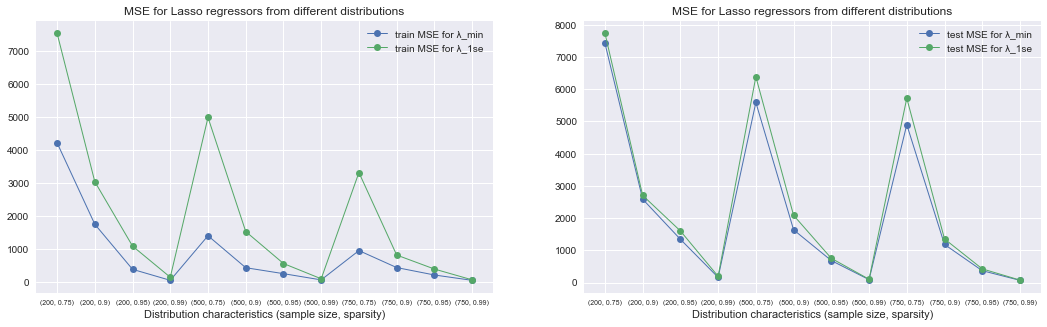

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Create labels for x-axis 
x = []

for n, s in product(sample_sizes, sparsity):
    x.append(f'{n, s}')

# Plot train MSE for both alpha_min & alpha_1se
ax[0].plot(train_scores_alpha_min, linewidth=1, marker='o', label='train MSE for λ_min')
ax[0].plot(train_scores_alpha_1se, linewidth=1, marker='o', label='train MSE for λ_1se')

# Plot test MSE for both alpha_min & alpha_1se
ax[1].plot(test_scores_alpha_min, linewidth=1, marker='o', label='test MSE for λ_min')
ax[1].plot(test_scores_alpha_1se, linewidth=1, marker='o', label='test MSE for λ_1se')


for i in range(len(ax)):
    ax[i].legend()
    plt.sca(ax[i])
    plt.xticks(range(len(x)), x, fontsize=7)
    plt.xlabel('Distribution characteristics (sample size, sparsity)')
    plt.title('MSE for Lasso regressors from different distributions')


plt.show()

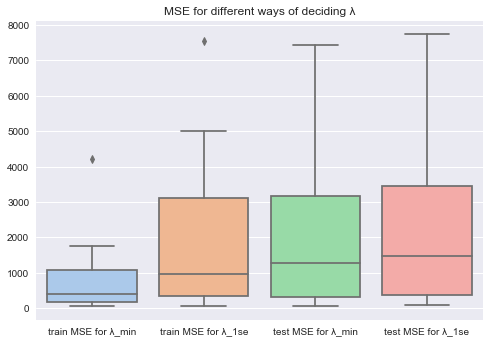

In [8]:
ax = sns.boxplot(
    x=['train MSE for λ_min', 'train MSE for λ_1se', 'test MSE for λ_min', 'test MSE for λ_1se'],
    y=[train_scores_alpha_min, train_scores_alpha_1se, test_scores_alpha_min, test_scores_alpha_1se],
    palette='pastel')
ax.set(title='MSE for different ways of deciding λ');

In [9]:
def zero_one_coding(beta):
    """0-1 encoding of active features.

    Parameters
    ----------
    beta : `p` numpy.array
        Vector of regression coefficients
    

    Returns
    -------
    beta : `p` numpy.array
        Updated vector of regression coefficients
    """
    idx = np.nonzero(beta)
    beta[idx] = 1

    return beta 

In [10]:
# 0-1 coding of selected features 
selected_features_est_amin = []
selected_features_est_a1se = []

for distributions in coefs_alpha_min:
    temp = []
    for beta_est in distributions:
        selected_features_est = zero_one_coding(beta_est)
        temp.append(selected_features_est)
    selected_features_est_amin.append(temp)

for distributions in coefs_alpha_1se:
    temp = []
    for beta_est in distributions:
        selected_features_est = zero_one_coding(beta_est)
        temp.append(selected_features_est)
    selected_features_est_a1se.append(temp)

In [11]:
# Get true coefficients 
beta_true = []
selected_features_true = []

for data in datasets:
    temp1 = []
    temp2 = []
    for d in data:
        beta = d[2]
        selected_features = zero_one_coding(beta)

        temp1.append(beta)
        temp2.append(selected_features)

    beta_true.append(temp1)
    selected_features_true.append(temp2)

In [12]:
from sklearn.metrics import recall_score

specificity_alpha_min = []
sensitivity_alpha_min = []

specificity_alpha_1se = []
sensitivity_alpha_1se = []

for i in range(len(datasets)):
    # Temporary storage of sensitivty & specificity from alpha_min
    temp1 = []
    temp2 = []
    # Temporary storage of sensitivty & specificity from alpha_1se
    temp3 = []
    temp4 = []

    for j in range(5):
        # Treat 0-1 encoding of selected features as binary classification
        y_true = selected_features_true[i][j]
        y_pred_alpha_min = selected_features_est_amin[i][j]
        y_pred_alpha_1se = selected_features_est_a1se[i][j]

        spec_amin = recall_score(y_true, y_pred_alpha_min, pos_label=0)
        sens_amin = recall_score(y_true, y_pred_alpha_min, pos_label=1)

        spec_a1se = recall_score(y_true, y_pred_alpha_1se, pos_label=0)
        sens_a1se = recall_score(y_true, y_pred_alpha_1se, pos_label=1)

        temp1.append(spec_amin)
        temp2.append(sens_amin)

        temp3.append(spec_a1se)
        temp4.append(sens_a1se)

    # Store mean of sensitivity/specificity for each data simluation setting
    specificity_alpha_min.append(np.mean(temp1))
    sensitivity_alpha_min.append(np.mean(temp2))

    specificity_alpha_1se.append(np.mean(temp3))
    sensitivity_alpha_1se.append(np.mean(temp4))

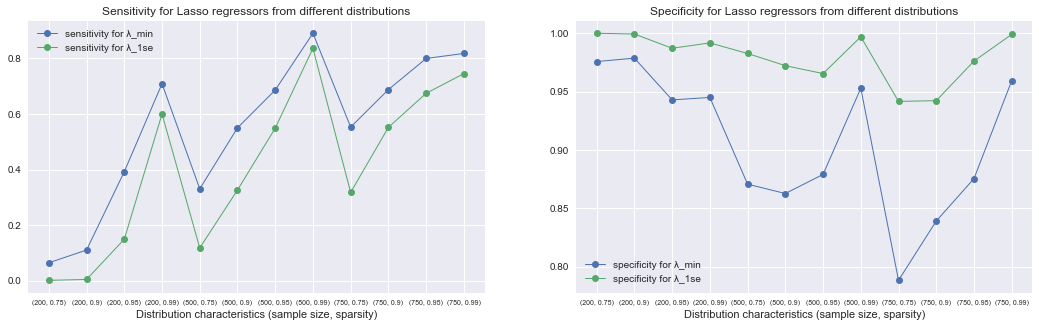

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot sensitivity for alpha_min & alpha_1se
ax[0].plot(sensitivity_alpha_min, linewidth=1, marker='o', label='sensitivity for λ_min')
ax[0].plot(sensitivity_alpha_1se, linewidth=1, marker='o', label='sensitivity for λ_1se')

# Plot specificity for alpha_min & alpha_1se
ax[1].plot(specificity_alpha_min, linewidth=1, marker='o', label='specificity for λ_min')
ax[1].plot(specificity_alpha_1se, linewidth=1, marker='o', label='specificity for λ_1se')


for i in range(len(ax)):
    t = 'Sensitivity' if i == 1 else 'Specificity'
    plt.title(f'{t} for Lasso regressors from different distributions')
    ax[i].legend()

    plt.sca(ax[i])
    plt.xticks(range(len(x)), x, fontsize=7)
    plt.xlabel('Distribution characteristics (sample size, sparsity)')


plt.show()

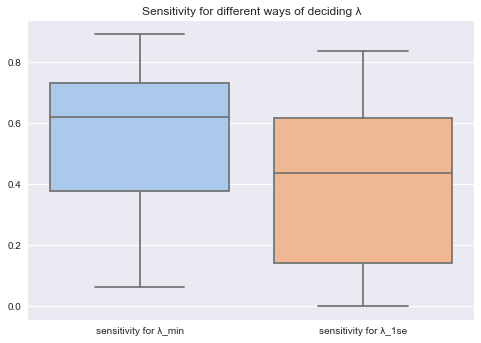

In [14]:
ax = sns.boxplot(
    x=['sensitivity for λ_min', 'sensitivity for λ_1se'],
    y=[sensitivity_alpha_min, sensitivity_alpha_1se],
    palette='pastel')
ax.set(title='Sensitivity for different ways of deciding λ');

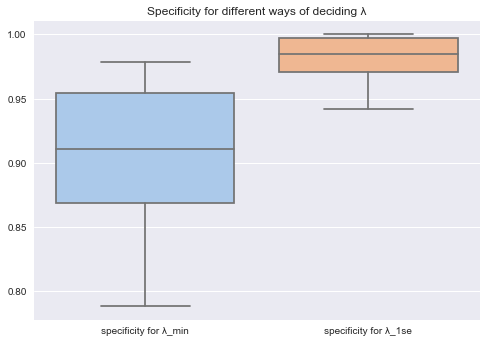

In [15]:
ax = sns.boxplot(
    x=['specificity for λ_min', 'specificity for λ_1se'],
    y=[specificity_alpha_min, specificity_alpha_1se],
    palette='pastel')
ax.set(title='Specificity for different ways of deciding λ');

# Part 2: Selecting features with confidence

### 1. Feature reduction

In [16]:
import pandas as pd

# Read csv-files with data
X = pd.read_csv("data.csv", index_col=0)
y = pd.read_csv("labels.csv", index_col=0)

# .ravel() sets the shape to (801) instead of (801,1)
y = np.array(y).ravel()

print(f'The dataset has {X.shape[1]} features and {X.shape[0]} samples, with {len(np.unique(y))} classes')

The dataset has 20531 features and 801 samples, with 5 classes


In [17]:
from sklearn.feature_selection import SelectKBest

# Feature reduction using F-statistic 
X_reduced = SelectKBest(k=200).fit_transform(X, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [    5    23  4370  4808  4809  4814  4816  4817  4831  5288  7661  7662
  7663  7664  7665  8121  9304  9306  9314  9316  9320  9452 10121 11958
 13991 14158 14159 14161 15138 15140 15141 15446 16566 16568 16569 16571
 16575 16578 16579 16604 16634 16637 16677 16697 16698 16699 16700 16701
 16702 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713 16714
 16715 16716 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726
 16727 16728 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738
 16739 16740 16741 16742 16743 16744 16745 16746 16748 16749 16750 16751
 16752 16753 16754 16756 16757 16758 16759 16760 16761 16762 16763 16764
 16765 16766 16767 16768 16769 16770 16771 16772 16774 16775 16776 16777
 16778 16779 16780 16781 16782 16783 16785 16787 16788 16789 16790 16791
 16792 16794 16795 16796 16798 16799 16800 16801 16802 16803 16804 16805
 16

### 2. Performing feature selection

In [18]:
from sklearn.linear_model import LogisticRegressionCV

# Regularization parameters to evaluate
c = np.logspace(-4, 4, 30)

clf = LogisticRegressionCV(
    multi_class='ovr', Cs=c, penalty='l1', 
    intercept_scaling=10_000, scoring='f1_macro', 
    solver='liblinear', cv=5)
clf.fit(X_reduced, y);


In [19]:
cs_1se = []

# Aggregate CV score by label
for label in np.unique(y):
    label_scores = clf.scores_[f'{label}']

    cv_mean = np.mean(label_scores, axis=0)
    cv_std = np.std(label_scores, axis=0)

    # Get smallest C-value that gives best recall score
    idx_max_mean = np.argmax(cv_mean)
    idx_c = np.where(
        (cv_mean >= cv_mean[idx_max_mean] - cv_std[idx_max_mean]) &
        (cv_mean <= cv_mean[idx_max_mean]))[0][0]
    
    # Optimal c according to 1se-rule
    c = clf.Cs_[idx_c]

    cs_1se.append(c)

In [20]:
# Check wether C-values according to 1se-rule differs from optimal C's
clf.C_ == cs_1se

array([ True,  True,  True,  True,  True])

### 3. Gaining confidence in the selection

In [22]:
from sklearn.linear_model import LogisticRegression

bootstrap_size = int(np.floor(0.75 * len(y)))
n_bootstraps = 50

unique_labels = np.unique(y)

tot_features_count = []

# Looping through each class, creating a binary classification for each
for label in unique_labels:
    
    # Initializing new labels y to 0 for binary classification
    y_bin = np.zeros(len(y))

    # Initializing frequency count of selected features to 0
    selected_features_count = np.zeros(200)

    # Getting indicies for each class
    idx_class = np.where(unique_labels == label)[0][0]

    # Setting all labels of current class to 1    
    for c in range(len(y)):
        if y[c] == 'label':
            y_bin[c] == 1
        else:
            pass
    
    for i in range(n_bootstraps):
        # Bootstrap sample 
        idx = np.random.choice(len(y), size=bootstrap_size, replace=True)
        X_sample, y_sample = X_reduced[idx], y[idx]

        # Create LR classifier with C-values from 1se-rule
        clf = LogisticRegression(
            multi_class='ovr', C=cs_1se[idx_class], penalty='l1', 
            intercept_scaling=10_000, solver='liblinear')
        clf.fit(X_reduced, y)

        # 0-1 coding of selected features for each class
        selected_features = zero_one_coding(clf.coef_[idx_class])

        selected_features_count += selected_features

    tot_features_count.append(selected_features_count)

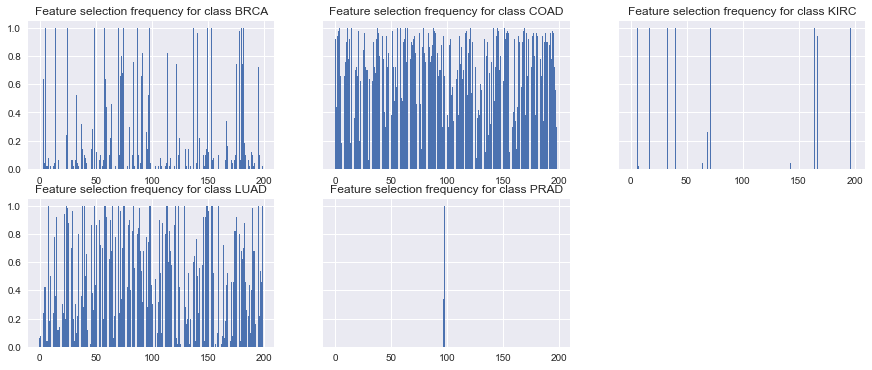

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey='row', figsize=(15, 6))

for i in range(ax.size):
    if i < 3:
        ax[0][i].bar(range(0,len(tot_features_count[i])), tot_features_count[i] / n_bootstraps)
        plt.sca(ax[0][i])
    elif i != 5:
        ax[1][i-3].bar(range(0,len(tot_features_count[i])), tot_features_count[i] / n_bootstraps)
        plt.sca(ax[1][i-3])
    else:
        ax[1][i-3].axis('off')

    if i < 5:
        plt.title(f'Feature selection frequency for class {unique_labels[i]}')

In [24]:
important_features = []

for index, features_count in enumerate(tot_features_count):
    # Get 5 most important features
    top_features = features_count.argsort()[-5:][::-1]
    important_features.append(top_features)

    print(f'\nMost important features for class {unique_labels[index]}: {top_features}')


Most important features for class BRCA: [ 25  87 182  98 153]

Most important features for class COAD: [199  38 141 145 107]

Most important features for class KIRC: [ 40  71 196 164  33]

Most important features for class LUAD: [199 160 153 150 149]

Most important features for class PRAD: [98 97 61 71 70]


In [25]:
# Compare top features between classes:
for i in range(len(important_features)):
    # Top features of current class
    current_class = important_features[i]

    for j in range(int(len(important_features)/2) + 1):
        if i != j:
            overlaps = np.intersect1d(current_class, important_features[j])
            if overlaps.size != 0:
                print(f'\n Both class {unique_labels[i]} & {unique_labels[j]} has {overlaps} among 5 most important features')
         


 Both class LUAD & BRCA has [153] among 5 most important features

 Both class LUAD & COAD has [199] among 5 most important features

 Both class PRAD & BRCA has [98] among 5 most important features

 Both class PRAD & KIRC has [71] among 5 most important features
